In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler 

# Utils

In [2]:
# Gauss 
def gauss(x,mu,s):
    #:params x: 1-D array data 
    #:prams mu,s: \mu and \sigma 
    #:return: \phi(x) 
    d = x.shape[0]
    m = mu.shape[0]
    phi = np.exp(-(x.reshape(-1,1) - mu)/(2*s**2))
    phi = np.concatenate(([1],phi.ravel()))
    return phi

# Function
def f(x):
    return 3*np.sin(x)

# Make Toy Data 
def make_toy_data(N,lower = 0,upper = 2*np.pi):
    X = np.random.rand(N)*(upper-lower) + lower
    y = f(X) + np.random.randn(N) 
    return X.reshape(-1,1),y.reshape(-1,1)


# Color maps 
cmaps = [[0.122, 0.467, 0.706],"orange","green"]

# Plot Prediction 
def plot_prediction(X_tr,y_tr,regressor,title,lower = 0,upper = 2*np.pi):
    X = np.linspace(lower,upper,100).reshape(-1,1)
    y_pred = regressor.predict(X) 
    y_true = f(X)
    
    fig,ax = plt.subplots(1,1,figsize = (10,7))
    ax.plot(X,y_pred,label="Predict",color=cmaps[0])
    ax.plot(X,y_true,label="Ground Truth",color=cmaps[1])
    ax.scatter(X_tr,y_tr,label="Training Data",color=cmaps[2])
    ax.set_title(title)
    
    plt.legend()
    plt.show()
    

# Plot Prediction with Std 
def plot_prediction_with_std(X_tr,y_tr,bayes_regressor,title,lower = 0,upper = 2*np.pi):
    X = np.linspace(lower,upper,100).reshape(-1,1)
    y_pred,y_std = bayes_regressor.predict(X,return_std=True)
    y_true = f(X)
    
    fig,ax = plt.subplots(1,1,figsize = (10,7))
    ax.plot(X,y_pred,label="Predict",color=cmaps[0])
    
    y_pred_upper = y_pred + y_std
    y_pred_lower = y_pred - y_std 
    ax.fill_between(X.ravel(),y_pred_lower.ravel(),y_pred_upper.ravel(),alpha=0.3,color=cmaps[0])
    
    ax.plot(X,y_true,label="Ground Truth",color=cmaps[1])
    ax.scatter(X_tr,y_tr,label="Training Data",color=cmaps[2])
    ax.set_title(title)
    
    plt.legend()
    plt.show()

# Maximum Likelihood

where $\Phi$ is a design matrix, $T$ is target matrix <br> 
<h3>
    $W_{ML} = (\Phi^T\Phi)^{-1}\Phi^T T$ <br> 
    $\frac{1}{\beta_{ML}} = \frac{1}{NK} \sum_{n = 1}^N ||t_n - W^T\phi(x_n)||^2$ 
</h3>

In [3]:
class LinearRegression():
    def __init__(self,mu = None,s = None):
        self.weight = None
        self.beta = None 
        self.mu = mu
        self.s = s
        self.phi = lambda x:gauss(x,self.mu,self.s)
        
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,N_targets)  
        N = X.shape[0] 
        K = y.shape[1] 
        design_mat = np.vstack([self.phi(x) for x in X])
        self.weight = np.dot(np.linalg.inv(design_mat.T@design_mat)@design_mat.T,y) 
        tmp = self.weight.T@design_mat.T 
        self.beta = N*K/np.sum((y - tmp)**2) 
        
    def predict(self,X):
        #:params X: 2-D array (N_samples,N_dims) N_dims = len(mu) = len(s) 
        design_mat = np.vstack([self.phi(x) for x in X])
        return np.dot(design_mat,self.weight)

In [4]:
X,y = make_toy_data(100)
X_tr,X_val,y_tr,y_val = train_test_split(X,y,test_size = 0.2,random_state = 0)

RMSE : 1.0316034769985785


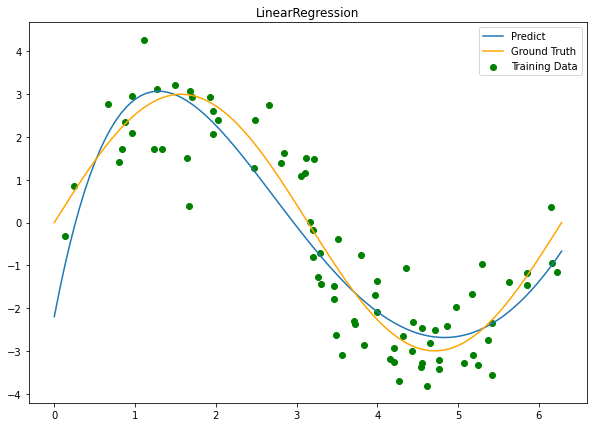

In [5]:
lr = LinearRegression(mu = np.array([0.1,0.5,1]),s = np.array([1,2,3]))
lr.fit(X_tr,y_tr)
pred_y = lr.predict(X_val)
print(f"RMSE : {mean_squared_error(pred_y,y_val)}")

plot_prediction(X_tr,y_tr,lr,"LinearRegression")

# Ridge
<p>
    almost same as LinearRegression but it has a regularization term. 
</p>

In [6]:
class Ridge():
    def __init__(self,lamda=1e-2,mu = None,s = None):
        self.weight = None
        self.lamda = lamda 
        self.mu = mu
        self.s = s
        self.phi = lambda x:gauss(x,self.mu,self.s)
        
    def fit(self,X,y):
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,N_targets)  
        N = X.shape[0] 
        K = y.shape[1]
        M = X.shape[1]*self.mu.shape[0] + 1
        design_mat = np.vstack([self.phi(x) for x in X])
        self.weight = np.dot(np.linalg.inv(self.lamda*np.eye(M) + design_mat.T@design_mat)@design_mat.T,y) 

    def predict(self,X):
        #:params X: 2-D array (N_samples,N_dims) N_dims = len(mu) = len(s) 
        design_mat = np.vstack([self.phi(x) for x in X])
        return np.dot(design_mat,self.weight)

RMSE : 1.0860950515453385


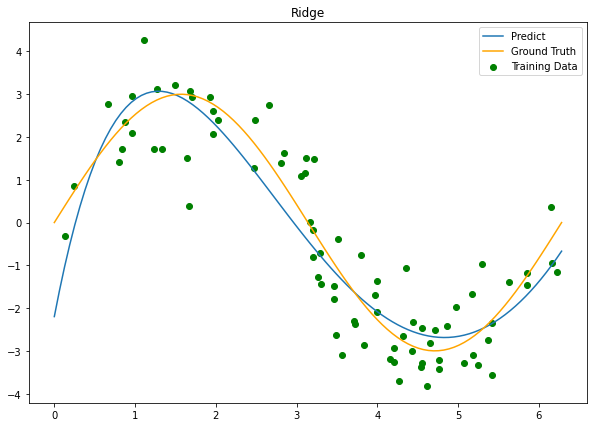

In [7]:
ridge = Ridge(lamda = 1e-5,mu = np.array([0.1,-0.5,1,2,-3,-0.1,0.3,0.4]),s = np.array([1,2,3,0.5,0.4,4,0.4,0.3]))  
ridge.fit(X_tr,y_tr)
pred_y = ridge.predict(X_val)
print(f"RMSE : {mean_squared_error(pred_y,y_val)}")

plot_prediction(X_tr,y_tr,lr,"Ridge")

# Bayesian Linear Regression

## Prior Distributin for Weight
### $$p(w|\alpha) = \mathcal{N}(w|0,\alpha^{-1}I)$$

<br> 

## Posterior Distribution for Weights
### $$p(w|t) = \mathcal{N}(w|m_N,S_N)$$
### where $$m_N = \beta S_N \Phi^\top t$$
### $$S_N^{-1} = \alpha I + \beta \Phi^\top \Phi$$

<br> 

## Predictive Distribution 
### $$p(t|x) = \mathcal{N}(t|m_N^\top\phi(x),\sigma_N^2(x))$$
### where $$\sigma_N^2(x) = \frac{1}{\beta} + \phi(x)^\top S_N\phi(x)$$

<br> 

## Evidence 
### $$\ln{p(t|\alpha,\beta)} = \frac{M}{2}\ln{\alpha} + \frac{N}{2}\ln{\beta} - E(m_N) + \frac{1}{2}\ln{|S_N|} - \frac{N}{2}\ln{2\pi}$$
### where $$E(m_N) = \frac{\beta}{2}||t - \Phi m_N||^2 + \frac{\alpha}{2}m_N^\top m_N$$

<br> 

## Maximizing the evidence function 
Let $\lambda_i$ be eigenvalue of $\beta\Phi^\top\Phi$
<h3>
    $$\gamma = \sum_{i = 1}^M \frac{\lambda_i}{\alpha + \lambda_i}$$ <br> 
    $$\alpha = \frac{\gamma}{m_N^\top m_N}$$ <br> 
    $$\frac{1}{\beta} = \frac{1}{N - \gamma}||t - \Phi m_N||^2$$
</h3>

In [8]:
class BayesianLinearRegression():
    def __init__(self,alpha = 1e-1,beta = 1e-1,mu = None,s = None):
        self.weight = None
        self.S = None
        self.M = None
        self.N = 0
        self.alpha = alpha 
        self.beta = beta 
        self.mu = mu
        self.s = s
        self.phi = lambda x:gauss(x,mu,s)
        
    def fit(self,X,y,optimize_evidence = False,n_iters = 20,threshold = 1e-3):
        #:params X: 2-D array (N_samples,N_dims)
        #:params y: 2-D array (N_samples,N_targets) 
        #:params optimze_evidence: if alpha and beta is optimized or not 
        
        self.N = X.shape[0]
        self.M = X.shape[1]*self.mu.shape[0] + 1
        
        if optimize_evidence:
            self.optimize_evidence_(X,y,n_iters,threshold) 
            
        design_mat = np.vstack([self.phi(x) for x in X])
        self.S = np.linalg.inv(self.alpha*np.eye(self.M) + self.beta*design_mat.T@design_mat) 
        self.weight = self.beta*self.S@design_mat.T@y 
    
    def partial_fit(self,X,y):
        # Before this method is called, fit() should be called 
        
        self.N += X.shape[0] 
        design_mat = np.vstack([self.phi(x) for x in X])
        S_old_inv = np.linalg.inv(self.S) 
        
        self.S = np.linalg.inv(S_old_inv + self.beta*design_mat.T@design_mat)
        self.weight = self.S@(S_old_inv@self.weight + self.beta*design_mat.T@y)
    
    def calc_evidence_(self,tmp):
        E = self.beta/2*tmp + self.alpha/2*np.dot(self.weight.T,self.weight) 
        evidence = self.M*np.log(self.alpha)/2 + self.N*np.log(self.beta)/2 - E + np.linalg.det(self.S) - self.N*np.log(2*np.pi)/2 
        return evidence 
    
    def optimize_evidence_(self,X,y,n_iters,threshold):
        #:params n_iters: Number of times to optimize alpha and beta 
        #:params threshold: If the difference of evidence is lower than this, 
        
        design_mat = np.vstack([self.phi(x) for x in X])
        C = design_mat.T@design_mat
        org_lambdas,_ = np.linalg.eig(C)
        with warnings.catch_warnings(): # Ignore Warnings
            warnings.simplefilter('ignore')
            org_lambdas = org_lambdas.astype(np.float64) 
        before_evidence = 10**10 
        
        for _ in range(n_iters):
            self.S = np.linalg.inv(self.alpha*np.eye(self.M) + self.beta*C) 
            self.weight = self.beta*self.S@design_mat.T@y 
            
            lambdas = self.beta*org_lambdas
            gamma = np.sum(lambdas/(lambdas + self.alpha))
            self.alpha = gamma/np.dot(self.weight.T,self.weight)
            tmp = y - design_mat@self.weight
            tmp = np.dot(tmp.T,tmp)
            self.beta = (self.N - gamma)/tmp 
            evidence = self.calc_evidence_(tmp)
            
            if np.abs(before_evidence-evidence) < threshold:
                break
            before_evidence = evidence
        
    def predict(self,X,return_std = False):
        design_mat = np.vstack([self.phi(x) for x in X])
        pred = np.dot(design_mat,self.weight).ravel()
        if return_std:
            std = np.sqrt(1/self.beta + np.diag(design_mat@self.S@design_mat.T))
            return pred,std
        else:
            return pred

RMSE : 1.066697446119702


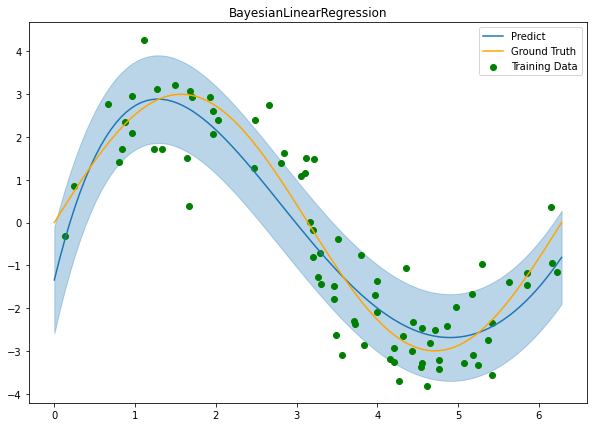

In [9]:
blr = BayesianLinearRegression(alpha = 1e-5,beta = 1,mu = np.random.randn(20),s = 10*np.random.randn(20))
blr.fit(X_tr,y_tr)
pred_y = blr.predict(X_val)
print(f"RMSE : {mean_squared_error(pred_y,y_val)}")

plot_prediction_with_std(X_tr,y_tr,blr,"BayesianLinearRegression")

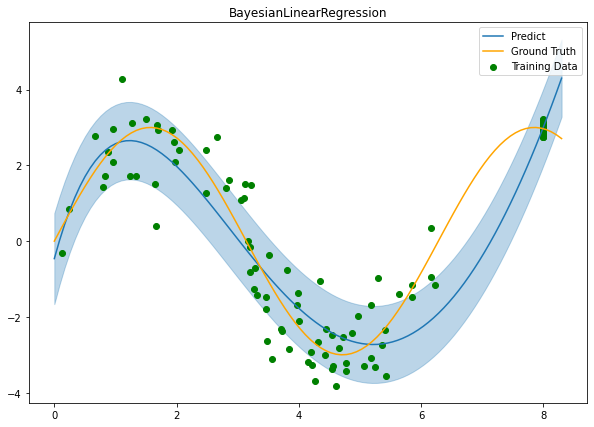

In [10]:
# Concentrated Data 

X_new = np.array([8]*40).reshape(-1,1)
y_new = f(X_new) + np.random.randn(40).reshape(-1,1)*0.1
blr.partial_fit(X_new,y_new)
plot_prediction_with_std(np.concatenate([X_tr,X_new]),
                         np.concatenate([y_tr,y_new]),
                         blr,"BayesianLinearRegression",lower = 0,upper = 8.3)

RMSE : 0.9738566831887081
Optimized alpha : 8.782704009728951e-08
Optimized beta : 1.2318654591121239


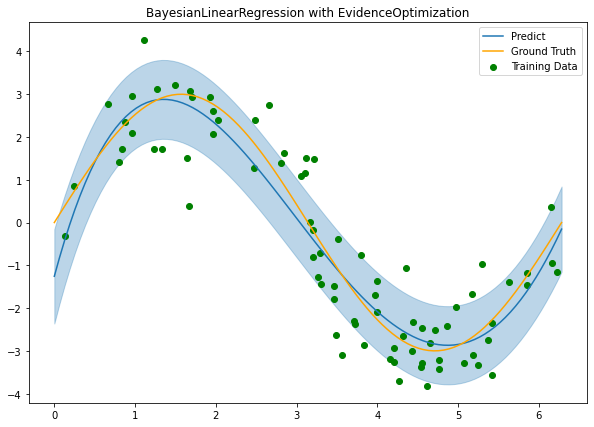

In [12]:
# With Evidence Optimization 

blr = BayesianLinearRegression(alpha = 1e-5,beta = 2,mu = np.random.randn(20),s = 10*np.random.randn(20))
blr.fit(X_tr,y_tr,optimize_evidence = True,n_iters = 20,threshold = 1e-3)
pred_y = blr.predict(X_val)
print(f"RMSE : {mean_squared_error(pred_y,y_val)}")
print(f"Optimized alpha : {blr.alpha[0][0]}")
print(f"Optimized beta : {blr.beta[0][0]}")

plot_prediction_with_std(X_tr,y_tr,blr,"BayesianLinearRegression with EvidenceOptimization")